# 3. RDD编程
本章介绍 Spark 对数据的核心抽象——弹性分布式数据集（Resilient Distributed Dataset，简称 RDD）。RDD 其实就是分布式的元素集合。在 Spark 中，对数据的所有操作不外乎创建 RDD、转化已有 RDD 以及调用 RDD 操作进行求值。而在这一切背后，Spark 会自动将 RDD 中的数据分发到集群上，并将操作并行化执行。

首先初始化Spark，本章的例子共用sc作为SparkContext：

In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local').setAppName('Demo')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local appName=Demo>

## 3.1 RDD基础
Spark 中的 RDD 就是一个不可变的分布式对象集合。每个 RDD 都被分为多个分区，这些分区运行在集群中的不同节点上。RDD 可以包含 Python、Java、Scala 中任意类型的对象，甚至可以包含用户自定义的对象。

用户可以使用两种方法创建 RDD：读取一个外部数据集，或在驱动器程序里分发驱动器程序中的对象集合（比如 list 和 set）。

**例3-1：在 Python 中使用 textFile() 创建一个字符串的 RDD**

In [2]:
lines = sc.textFile("README.md")

RDD支持两种类型的操作：转化操作（transformation） 和行动操作（action）。

转化操作会由一个 RDD 生成一个新的 RDD。例如，根据谓词匹配情况筛选数据就是一个常见的转化操作。在我们的文本文件示例中，我们可以用筛选来生成一个只存储包含单词 Python 的字符串的新的 RDD。

**例 3-2：调用转化操作 filter()**

In [3]:
pythonLines = lines.filter(lambda line: "Python" in line)

行动操作会对 RDD 计算出一个结果，并把结果返回到驱动器程序中，或把结果存储到外部存储系统（如 HDFS）中。first() 就是我们之前调用的一个行动操作，它会返回 RDD 的第一个元素。

**例 3-3：调用 first() 行动操作**

In [4]:
pythonLines.first()

'* The Python examples require urllib3'

转化操作和行动操作的区别在于 Spark 计算 RDD 的方式不同。虽然你可以在任何时候定义新的 RDD，但 Spark 只会惰性计算这些 RDD。它们只有第一次在一个行动操作中用到时，才会真正计算。

默认情况下，Spark 的 RDD 会在你每次对它们进行行动操作时重新计算。如果想在多个行动操作中重用同一个 RDD，可以使用 `RDD.persist()` 让 Spark 把这个 RDD 缓存下来。在第一次对持久化的 RDD 计算之后，Spark 会把 RDD 的内容保存到内存中（以分区方式存储到集群中的各机器上），这样在之后的行动操作中，就可以重用这些数据了。我们也可以把 RDD 缓存到磁盘上而不是内存中。默认不进行持久化可能也显得有些奇怪，不过这对于大规模数据集是很有意义的：如果不会重用该 RDD，我们就没有必要浪费存储空间，Spark 可以直接遍历一遍数据然后计算出结果。

> 在任何时候都能进行重算是我们为什么把 RDD 描述为“弹性”的原因。当保存 RDD 数据的一台机器失败时，Spark 还可以使用这种特性来重算出丢掉的分区，这一过程对用户是完全透明的。

在实际操作中，你会经常用 persist() 来把数据的一部分读取到内存中，并反复查询这部分数据。例如，如果我们想多次对 README 文件中包含 Python 的行进行计算，就可以写出这样的脚本：

```python
pythonLines.persist
pythonLines.count()
pythonLines.first()
```

**总的来说，每个 Spark 程序或 shell 会话都按如下方式工作:**
1. 从外部数据创建出输入 RDD
2. 使用诸如 filter() 这样的转化操作对 RDD 进行转化，以定义新的 RDD
3. 告诉 Spark 对需要被重用的中间结果 RDD 执行 persist() 操作
4. 使用行动操作来触发一次并行计算，Spark 会对计算进行优化后再执行

> cache() 与使用默认存储级别调用 persist() 是一样的

## 3.2 创建RDD
Spark 提供了两种创建 RDD 的方式：读取外部数据集，以及在驱动器程序中对一个集合进行并行化。

创建 RDD 最简单的方式就是把程序中一个已有的集合传给 SparkContext 的 parallelize() 方法，这种方式在学习 Spark 时非常有用，它让你可以在 shell 中快速创建出自己的 RDD，然后对这些 RDD 进行操作。不过，需要注意的是，除了开发原型和测试时，这种方式用得并不多，毕竟这种方式需要把你的整个数据集先放在一台机器的内存中。

**例 3-5：Python 中的 parallelize() 方法**

In [5]:
lines = sc.parallelize(["pandas", "i like pandas"])

## 3.3 RDD操作
Spark 对待转化操作和行动操作的方式很不一样，因此理解你正在进行的操作的类型是很重要的。如果对于一个特定的函数是属于转化操作还是行动操作感到困惑，你可以看看它的返回值类型：转化操作返回的是 RDD，而行动操作返回的是其他的数据类型。

### 3.3.1 转化操作
转化操作是返回新 RDD 的操作，转化出来的 RDD 是惰性求值的，只有在行动操作中用到这些 RDD 时才会被计算。

**例 3-11：用 Python 实现 filter() 转化操作**

In [6]:
inputRDD = sc.textFile("log.txt")
errorsRDD = inputRDD.filter(lambda x: "error" in x)

filter() 操作不会改变已有的 inputRDD 中的数据，该操作会返回一个全新的 RDD。接下来，我们使用另一个转化操作 union() 来打印出包含 error 或 warning 的行数。

**例 3-14：用 Python 进行 union() 转化操作**

In [7]:
warningsRDD = inputRDD.filter(lambda x: "warning" in x)
badLinesRDD = errorsRDD.union(warningsRDD)
badLinesRDD.count()

6

Spark 会使用谱系图（lineage graph）来记录这些不同 RDD 之间的依赖关系。Spark 需要用这些信息来按需计算每个 RDD，也可以依靠谱系图在持久化的 RDD 丢失部分数据时恢复所丢失的数据。下图展示了以上创建的RDD的谱系图：

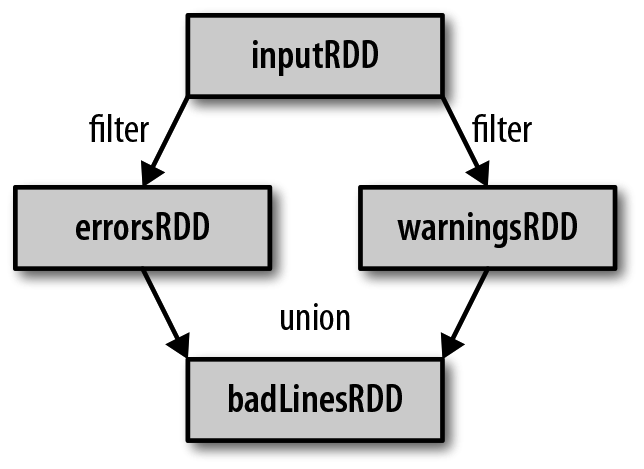


### 3.3.2 行动操作
由于行动操作需要生成实际的输出，它们会强制执行那些求值必须用到的 RDD 的转化操作。

下面的例子用`count()`来返回计数结果，用`take()`来收集 RDD 中的一些元素。

**例 3-15：在 Python 中使用行动操作对错误进行计数**

In [8]:
print("Input had %i %s" % (badLinesRDD.count(), "concerning lines"))
print("Here are 2 examples:")
for line in badLinesRDD.take(2):
    print(".. %s" % (line))

Input had 6 concerning lines
Here are 2 examples:
.. 17 Nov 10:25:28 ntpd[849]: error: Unexpected origin timestamp from 100.100.5.2
.. 17 Nov 10:25:28 ntpd[849]: error: Unexpected origin timestamp from 100.100.3.3


RDD 还有一个 collect() 函数，可以用来获取整个 RDD 中的数据。只有当你的整个数据集能在单台机器的内存中放得下时，才能使用 collect()，collect() 不能用在大规模数据集上。

在大多数情况下我们通常要把数据写到诸如 HDFS 或 Amazon S3 这样的分布式的存储系统中。你可以使用 saveAsTextFile()、saveAsSequenceFile()，或者任意的其他行动操作来把 RDD 的数据内容以各种自带的格式保存起来。

需要注意的是，每当我们调用一个新的行动操作时，整个 RDD 都会从头开始计算。要避免这种低效的行为，用户可以将中间结果持久化。

## 3.4 向Spark传递函数
Spark 的大部分转化操作和一部分行动操作，都需要依赖用户传递的函数来计算。在我们支持的三种主要语言中，向 Spark 传递函数的方式略有区别。

### 3.4.1 Python
**例 3-18：在 Python 中传递函数**

```python
word = rdd.filter(lambda s: "error" in s)

def containsError(s):
    return "error" in s
word = rdd.filter(containsError)
```

传递函数时需要小心的一点是，Python 会在你不经意间把函数所在的对象也序列化传出去。当你传递的对象是某个对象的成员，或者包含了对某个对象中一个字段的引用时（例如`self.field`），Spark 就会把整个对象发到工作节点上，这可能比你想传递的东西大得多。有时，如果传递的类里面包含 Python 不知道如何序列化传输的对象，也会导致你的程序失败。

**例 3-19：传递一个带字段引用的函数（别这么做！）**
```python
class SearchFunctions(object):
  def __init__(self, query):
      self.query = query
  def isMatch(self, s):
      return self.query in s
  def getMatchesFunctionReference(self, rdd):
      # 问题：在"self.isMatch"中引用了整个self
      return rdd.filter(self.isMatch)
  def getMatchesMemberReference(self, rdd):
      # 问题：在"self.query"中引用了整个self
      return rdd.filter(lambda x: self.query in x)
```

替代的方案是，只把你所需要的字段从对象中拿出来放到一个局部变量中，然后传递这个局部变量。

**例 3-20：传递不带字段引用的 Python 函数**
```python
class WordFunctions(object):
  ...
  def getMatchesNoReference(self, rdd):
      # 安全：只把需要的字段提取到局部变量中
      query = self.query
      return rdd.filter(lambda x: query in x)
```

### 3.4.2 Scala
在 Scala 中，我们可以把定义的内联函数、方法的引用或静态方法传递给 Spark，就像 Scala 的其他函数式 API 一样。我们还要考虑其他一些细节，比如所传递的函数及其引用的数据需要是可序列化的（实现了 Java 的 Serializable 接口）。除此以外，与 Python 类似，传递一个对象的方法或者字段时，会包含对整个对象的引用。

**例 3-21：Scala 中的函数传递**
```java
class SearchFunctions(val query: String) {
  def isMatch(s: String): Boolean = {
    s.contains(query)
  }
  def getMatchesFunctionReference(rdd: RDD[String]): RDD[String] = {
    // 问题："isMatch"表示"this.isMatch"，因此我们要传递整个"this"
    rdd.map(isMatch)
  }
  def getMatchesFieldReference(rdd: RDD[String]): RDD[String] = {
    // 问题："query"表示"this.query"，因此我们要传递整个"this"
    rdd.map(x => x.split(query))
  }
  def getMatchesNoReference(rdd: RDD[String]): RDD[String] = {
    // 安全：只把我们需要的字段拿出来放入局部变量中
    val query_ = this.query
    rdd.map(x => x.split(query_))
  }
}
```

## 3.5 常见的转化操作和行动操作
本节我们会接触 Spark 中大部分常见的转化操作和行动操作。

### 3.5.1 基本RDD
首先来讲讲哪些转化操作和行动操作受任意数据类型的 RDD 支持。

#### 1. 针对各个元素的转化操作
你很可能会用到的两个最常用的转化操作是 map() 和 filter()。转化操作 map() 接收一个函数，把这个函数用于 RDD 中的每个元素，将函数的返回结果作为结果 RDD 中对应元素的值。而转化操作 filter() 则接收一个函数，并将 RDD 中满足该函数的元素放入新的 RDD 中返回。

**例 3-26：Python 版计算 RDD 中各值的平方**

In [9]:
nums = sc.parallelize([1, 2, 3, 4])
squared = nums.map(lambda x: x * x).collect()
squared

[1, 4, 9, 16]

有时候，我们希望对每个输入元素生成多个输出元素。实现该功能的操作叫作 flatMap()。和 map() 类似，我们提供给 flatMap() 的函数被分别应用到了输入 RDD 的每个元素上。不过返回的不是一个元素，而是一个返回值序列的迭代器。输出的 RDD 倒不是由迭代器组成的。我们得到的是一个包含各个迭代器可访问的所有元素的 RDD。

**例 3-29：Python 中的 flatMap() 将行数据切分为单词**

In [10]:
lines = sc.parallelize(["hello world", "hi"])
words = lines.flatMap(lambda line: line.split(" "))
words.first()

'hello'

#### 2. 伪集合操作
RDD支持许多数学上的集合操作，下图展示了四种操作。注意，这些操作都要求操作的 RDD 是相同数据类型的。

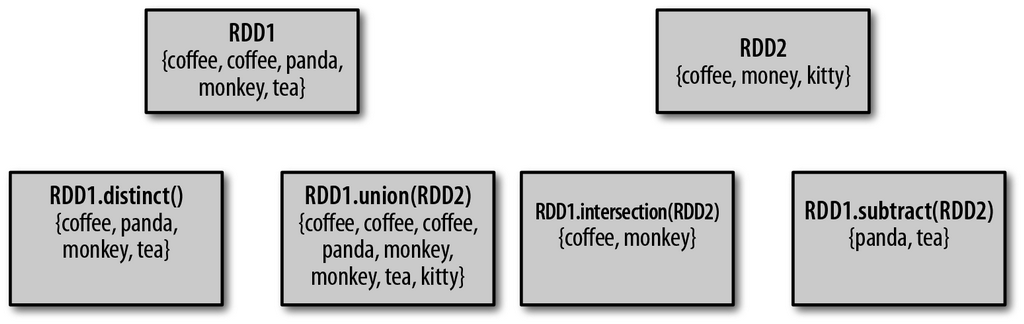

+ RDD.distinct()转化操作来生成一个只包含不同元素的新RDD。不过需要注意，distinct()操作的开销很大，因为它需要将所有数据通过网络进行混洗，以确保每个元素都只有一份
+ union(other)会返回一个包含两个RDD中所有元素的RDD。与数学中的union()操作不同的是，如果输入的RDD中有重复数据，Spark的union()操作也会包含这些重复数据
+ intersection(other)方法返回两个RDD中都有的元素。intersection()在运行时也会去掉所有重复的元素，因此它需要通过网络混洗数据来发现共有的元素
+ subtract(other)函数接收另一个RDD作为参数，返回一个由只存在于第一个RDD中而不存在于第二个RDD中的所有元素组成的RDD。它也需要数据混洗

#### 3. 行动操作
reduce()接收一个函数作为参数，操作两个相同元素类型的RDD数据并返回一个同样类型的新元素。

In [11]:
nums = sc.parallelize([1, 2, 3, 4])
sum = nums.reduce(lambda x, y: x + y)
sum

10

In [12]:
nums = sc.parallelize([1, 2, 3, 4])
num = nums.reduce(lambda x, _: x + 1)
num

4

fold()和reduce()类似，接收一个函数，再加上一个“初始值”来作为每个分区第一次调用时的结果。fold方法需要输入两个参数：初始值以及一个函数。输入的函数也需要输入两个参数：累加值和当前item的索引。那么上面的代码片段发生了什么事？代码开始运行的时候，初始值0作为第一个参数传进到fold函数中，list中的第一个item作为第二个参数传进fold函数中。

In [13]:
nums = sc.parallelize([1, 2, 3, 4, 5])
sum = nums.fold(0, lambda x, y: x + y)
sum

15

fold()和reduce()都要求函数的返回值类型需要和我们所操作的RDD中的元素类型相同，aggregate()函数则不需要。与fold()类似，使用aggregate() 时，需要提供我们期待返回的类型的初始值。然后通过一个函数把RDD中的元素合并起来放入累加器。考虑到每个节点是在本地进行累加的，最终，还需要提供第二个函数来将累加器两两合并。*关于reduce、fold、aggregate的原理，参考https://www.jianshu.com/p/15739e95a46e*

我们可以用aggregate()来计算RDD的平均值，来代替map()后面接fold()的方式。

**例 3-35：Python 中的 aggregate()**

In [14]:
nums = sc.parallelize([1, 2, 3, 4, 5])
sumCount = nums.aggregate((0, 0), 
                          (lambda acc, value: (acc[0] + value, acc[1] + 1)),
                          (lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])))
sumCount[0] / float(sumCount[1])

3.0

**一个数据为{1, 2, 3, 3}的RDD进行基本的RDD行动操作**
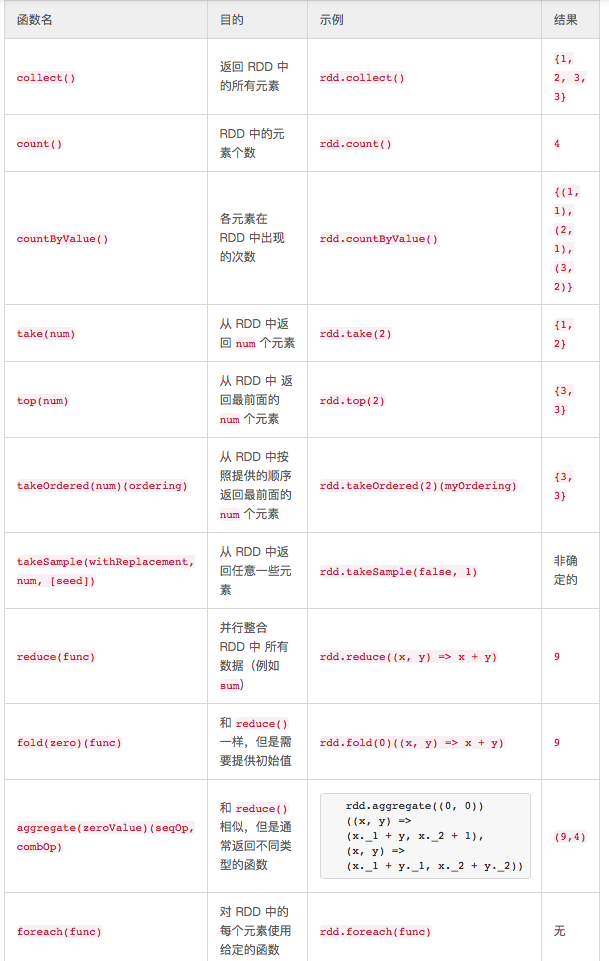

## 3.6 持久化(缓存)
persist()通过不同的参数控制持久化，如下表所示：
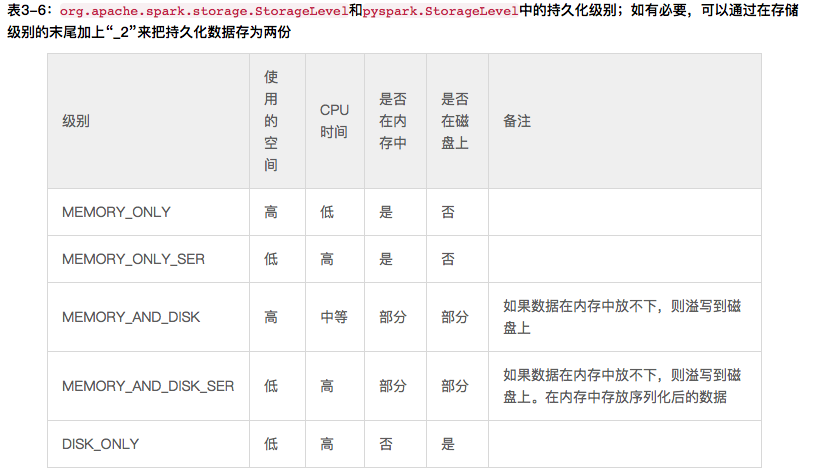

如果要缓存的数据太多，内存中放不下，Spark 会自动利用最近最少使用（LRU）的缓存策略把最老的分区从内存中移除。对于仅把数据存放在内存中的缓存级别，下一次要用到已经被移除的分区时，这些分区就需要重新计算。但是对于使用内存与磁盘的缓存级别的分区来说，被移除的分区都会写入磁盘。不论哪一种情况，都不必担心你的作业因为缓存了太多数据而被打断。不过，缓存不必要的数据会导致有用的数据被移出内存，带来更多重算的时间开销。

最后，RDD 还有一个方法叫作 unpersist()，调用该方法可以手动把持久化的 RDD 从缓存中移除。